In [8]:
import requests
from bs4 import BeautifulSoup
import pycountry
import csv
import json
# URL of the ISO 639-3 table
iso_639_3_url = "https://iso639-3.sil.org/sites/iso639-3/files/downloads/iso-639-3.tab"

# Download and save the table
response = requests.get(iso_639_3_url)
with open("./data/iso-639-3.tab", "wb") as f:
    f.write(response.content)

print("ISO 639-3 table downloaded and saved as 'iso-639-3.tab'")


# Load ISO 639-3 data from the iso-639-3.tab file
def load_iso_639_3_table(file_path="./data/iso-639-3.tab"):
    iso_639_3_codes = set()
    with open(file_path, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f, delimiter="\t")
        for row in reader:
            iso_639_3_codes.add(row["Id"])  # Add the ISO 639-3 code (ID column)
    return iso_639_3_codes


# Load the ISO 639-3 code set
iso_639_3_codes = load_iso_639_3_table()

def get_iso_code(code, name):
    # First, try using ISO 639-1 alpha-2 code if available
    try:
        lang = pycountry.languages.get(alpha_2=code)
        if lang and lang.alpha_3:
            return lang.alpha_3
    except LookupError:
        pass

    # If alpha-2 lookup fails, try looking up by language name
    try:
        lang = pycountry.languages.lookup(name)
        return lang.alpha_3
    except LookupError:
        pass

    # If previous checks fail, directly check if the 3-letter code exists in ISO 639-3
    if code in iso_639_3_codes:
        return code  # Map directly if it exists in ISO 639-3

    return "Unknown"



ISO 639-3 table downloaded and saved as 'iso-639-3.tab'


In [9]:


# URL of the Wikipedia page containing the table
url = "https://meta.wikimedia.org/wiki/List_of_Wikipedias"

# Fetch the page content
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/117.0.0.0 Safari/537.36"
}

response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, "html.parser")

# Find the first table on the page
table = soup.find("table")

# Check if the table was found
if not table:
    print("Table not found on the page.")
    

# Get all the rows in the table
rows = table.find_all("tr")

# Create the dictionary to map wiki codes to ISO codes
wiki_code_to_iso_code = {}

# Open the output file with UTF-8 encoding
with open("./data/iso_codes_of_wikis.txt", "w", encoding="utf-8") as f:
    # Iterate over the rows, skipping the header rows
    for row in rows[1:]:
        cells = row.find_all(["td", "th"])
        if len(cells) >= 7:
            # Extract the language code from the fourth cell
            code_cell = cells[3]
            code_link = code_cell.find("a")
            if code_link and code_link.text.strip():
                code = code_link.text.strip()
            else:
                code = code_cell.text.strip()

            # Extract the English language name from the third cell
            language_name = cells[2].text.strip()

            # Get the ISO code using the main and fallback methods
            iso_code = get_iso_code(code, language_name)

            # Add the mapping to the dictionary
            wiki_code_to_iso_code[code] = iso_code

            # Write the output to the file
            f.write(f"{language_name} ({code}): {iso_code}\n")

# Save the dictionary
with open("./data/wiki_code_to_iso_code.json", "w", encoding="utf-8") as json_file:
    json.dump(wiki_code_to_iso_code, json_file, ensure_ascii=False, indent=4)

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the ISO 639-2 code list
url = "https://www.loc.gov/standards/iso639-2/php/code_list.php"

# Fetch the HTML content
response = requests.get(url)
response.raise_for_status()  # ensure the request succeeded

# Parse the HTML with BeautifulSoup
soup = BeautifulSoup(response.text, "html.parser")

# Find the main table
table = soup.find("table")

# Extract column headers
headers = [th.get_text(strip=True) for th in table.find_all("th")]

# Extract table rows
rows = []
for tr in table.find_all("tr")[1:]:  # skip header row
    cells = [td.get_text(strip=True) for td in tr.find_all("td")]
    if cells:
        rows.append(cells)

# Convert to DataFrame
df = pd.DataFrame(rows, columns=headers)

# Show first few rows
print(df.head())

# (Optional) Save to CSV
df.to_csv("iso_639_1_2_codes.csv", index=False, encoding="utf-8")
print("✅ Saved as iso_639_1_2_codes.csv")


  ISO 639-2 Code ISO 639-1 Code English name of Language  \
0            aar             aa                     Afar   
1            abk             ab                Abkhazian   
2            ace                                Achinese   
3            ach                                   Acoli   
4            ada                                 Adangme   

  French name of Language German name of Language  
0                    afar         Danakil-Sprache  
1                 abkhaze              Abchasisch  
2                    aceh            Aceh-Sprache  
3                   acoli          Acholi-Sprache  
4                 adangme         Adangme-Sprache  
✅ Saved as iso_639_1_2_codes.csv


In [ ]:
from selenium import webdriver
from selenium.webdriver.edge.service import Service
from selenium.webdriver.edge.options import Options
from selenium.webdriver.common.by import By
import time
import random
import pandas as pd

# ====== User settings ======
EDGE_DRIVER_PATH = "/usr/local/bin/msedgedriver"  # path to msedgedriver
WAIT_BETWEEN = (1, 2)  # random wait between requests

# ====== Selenium setup ======
options = Options()
# Run actual browser
# options.add_argument("--headless")  # <-- Do NOT use headless
options.add_argument("--disable-gpu")
options.add_argument("--window-size=1920,1080")
options.add_argument("--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                     "AppleWebKit/537.36 (KHTML, like Gecko) "
                     "Chrome/118.0.5993.90 Safari/537.36 Edg/118.0.2088.61")

service = Service(EDGE_DRIVER_PATH)
driver = webdriver.Edge(service=service, options=options)

# ====== Function to check site ======
def check_site_selenium(code, iso1=None, iso2=None):
    url = f"https://wol.jw.org/{code}"
    visited_urls = []

    try:
        driver.get(url)
        time.sleep(random.uniform(1, 2))  # let page load
        visited_urls.append(driver.current_url)

        # Build possible valid prefixes
        valid_prefixes = [f"https://wol.jw.org/{code.lower()}/"]
        if iso1 and iso1.strip():
            valid_prefixes.append(f"https://wol.jw.org/{iso1.strip().lower()}/")
        if iso2 and iso2.strip():
            valid_prefixes.append(f"https://wol.jw.org/{iso2.strip().lower()}/")

        final_url = driver.current_url.lower()
        if any(final_url.startswith(v) for v in valid_prefixes):
            status = "Exists"
        elif "/en/" in final_url or final_url.rstrip("/") == "https://wol.jw.org/en":
            status = "Redirected to EN"
        else:
            status = f"Redirected to {final_url}"

        return status, visited_urls

    except Exception as e:
        return f"Error: {e}", visited_urls

# ====== Test ISO codes ======
def test_iso_codes_selenium(df):
    df = df.copy()
    df["JW_for_iso1_status"] = None
    # df["JW_for_iso1_urls"] = None
    df["JW_for_iso2_status"] = None
    # df["JW_for_iso2_urls"] = None

    for idx, row in df.iterrows():
        iso1 = str(row.get("ISO 639-1 Code", "")).strip()
        iso2 = str(row.get("ISO 639-2 Code", "")).strip()

        # Test 2-letter code
        if iso1 and iso1 != "-":
            status, urls = check_site_selenium(iso1, iso1=iso1, iso2=iso2)
            df.at[idx, "JW_for_iso1_status"] = status
            # df.at[idx, "JW_for_iso1_urls"] = " -> ".join(urls)
        else:
            df.at[idx, "JW_for_iso1_status"] = "N/A"
            # df.at[idx, "JW_for_iso1_urls"] = ""

        # Test 3-letter code
        if iso2 and iso2 != "-":
            status, urls = check_site_selenium(iso2, iso1=iso1, iso2=iso2)
            df.at[idx, "JW_for_iso2_status"] = status
           #  df.at[idx, "JW_for_iso2_urls"] = " -> ".join(urls)
        else:
            df.at[idx, "JW_for_iso2_status"] = "N/A"
            # df.at[idx, "JW_for_iso2_urls"] = ""

        time.sleep(random.uniform(*WAIT_BETWEEN))

    return df

# ====== Example usage ======
# df = pd.read_csv("iso_639_codes.csv", encoding="utf-8")
# df_cut = df.head(20)  # test first 20 rows
results_df = test_iso_codes_selenium(df)

results_df["has_bible"] = results_df.apply(
    lambda row: 1 if ("Exists" in str(row["JW_for_iso1_status"]) or "Exists" in str(row["JW_for_iso2_status"])) else 0,
    axis=1
)

results_df.to_csv("jw_availability_by_iso.csv", index=False, encoding="utf-8")
print("✅ Completed. See jw_availability_by_iso.csv")

# Close browser after completion
driver.quit()


✅ Completed. See jw_availability_by_iso.csv


In [ ]:
results_df

,ISO 639-2 Code,ISO 639-1 Code,English name of Language,French name of Language,German name of Language,JW_for_iso1_status,JW_for_iso2_status,Does_have_bible
0,aar,aa,Afar,afar,Danakil-Sprache,Redirected to EN,Redirected to EN,0
1,abk,ab,Abkhazian,abkhaze,Abchasisch,Exists,Exists,1
2,ace,,Achinese,aceh,Aceh-Sprache,N/A,Redirected to EN,0
3,ach,,Acoli,acoli,Acholi-Sprache,N/A,Exists,1
4,ada,,Adangme,adangme,Adangme-Sprache,N/A,Exists,1
5,ady,,Adyghe; Adygei,adyghé,Adygisch,N/A,Exists,1
6,afa,,Afro-Asiatic languages,"afro-asiatiques, langues",Hamitosemitische Sprachen (Andere),N/A,Redirected to EN,0
7,afh,,Afrihili,afrihili,Afrihili,N/A,Redirected to EN,0
8,afr,af,Afrikaans,afrikaans,Afrikaans,Exists,Exists,1
9,ain,,Ainu,aïnou,Ainu-Sprache,N/A,Redirected to EN,0


In [ ]:
# fenti 2 cellát eltenni .py fileba a rendes scriptekbe meg a 2 adat csv-t

In [7]:
import json
file_path = "./data/WPincubatornew.json"
# Simple: read flat JSON of numeric values, write sums (same keys) to existing out_f
try:
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
except Exception as e:
    print(f"Error reading {file_path}: {e}")
    data = {}

sums_dict = {}
if isinstance(data, dict):
    for k, v in data.items():
        try:
            n = float(v)
            # keep integers as int for nicer output
            sums_dict[k] = int(n) if n.is_integer() else n
        except Exception:
            # ignore non-numeric values
            pass
else:
    print("Expected a flat dict in JSON (key: number).")

# Print sorted by descending value
for k, v in sorted(sums_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{k}: {v}")


total_sum = sum(sums_dict.values())
print(f"Total sum: {total_sum}")



aae: 1
aar: 1
abq: 1
ach: 1
acm: 1
ada: 1
aeb: 1
afb: 1
ahr: 1
aii: 1
ain: 1
ajg: 1
aju: 1
akf: 1
akg: 1
akl: 1
akr: 1
akz: 1
ale: 1
aln: 1
amu: 1
ann: 1
aoc: 1
apc: 1
apw: 1
aqc: 1
arn: 1
aro: 1
arq: 1
ars: 1
ase: 1
ayh: 1
ayl: 1
bax: 1
bbj: 1
bca: 1
bcc: 1
bci: 1
bem: 1
bfa: 1
bfq: 1
bgc: 1
bgn: 1
bgp: 1
bgx: 1
bgz: 1
bhb: 1
bhh: 1
bhi: 1
bhp: 1
bin: 1
bkm: 1
bnn: 1
bol: 1
bom: 1
bph: 1
bqi: 1
bra: 1
brh: 1
brx: 1
bsh: 1
bth: 1
bto: 1
bts: 1
btx: 1
btz: 1
bwr: 1
bzj: 1
cak: 1
ccp: 1
chb: 1
chn: 1
cho: 1
cia: 1
cjm: 1
cjs: 1
cjy: 1
cko: 1
ckt: 1
ckv: 1
clm: 1
clw: 1
cng: 1
cni: 1
cnr: 1
cnu: 1
cop: 1
cpi: 1
cps: 1
cpx: 1
crk: 1
crs: 1
csn: 1
csp: 1
ctg: 1
czh: 1
czo: 1
dar: 1
ddn: 1
dgo: 1
dis: 1
dje: 1
dlg: 1
dng: 1
dnj: 1
dru: 1
dua: 1
efi: 1
ekp: 1
eky: 1
enf: 1
esg: 1
esu: 1
evn: 1
fit: 1
fkv: 1
frc: 1
frs: 1
fvr: 1
gaa: 1
gay: 1
gbm: 1
gcf: 1
gct: 1
gdo: 1
gil: 1
gld: 1
grc: 1
grt: 1
haa: 1
hac: 1
har: 1
her: 1
hil: 1
hji: 1
hke: 1
hmo: 1
hmr: 1
hne: 1
hni: 1
hoc: 1
hrx: 1
hsn: 1

In [4]:
import os
import random
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# === CONFIG ===
MASTER_CSV = "../data/master_features_by_code.csv"
SEED_DIR = "../langdeath/classification/seed_data"
SAMPLE_PER_CLASS = 50
OUTPUT_MATRIX = "../data/feature_class_significance.csv"

# === LOAD MASTER DATA ===
df = pd.read_csv(MASTER_CSV)

# if cols 'iso639_3' and 'glottocode' exist, remove them
for col in ["iso639_3", "glottocode"]:
    if col in df.columns:
        df = df.drop(columns=[col])


df = df.set_index(df.columns[0])  # assume first col is code
print(f"Loaded master data with {df.shape[0]} rows, {df.shape[1]} cols")

# Identify numeric feature columns
feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Detected {len(feature_cols)} numeric features.")

# === LOAD CLASS SEEDS ===
seed_files = [f for f in os.listdir(SEED_DIR) if os.path.isfile(os.path.join(SEED_DIR, f))]
class_to_codes = {}

for sf in seed_files:
    label = os.path.splitext(sf)[0]  # e.g. 'g', 't', 's', etc.
    with open(os.path.join(SEED_DIR, sf), encoding="utf-8") as f:
        codes = [line.strip() for line in f if line.strip()]
    class_to_codes[label] = codes

print(f"Loaded {len(class_to_codes)} classes: {list(class_to_codes.keys())}")

# === SAMPLE DATA ===
samples = []
for label, codes in class_to_codes.items():
    subset = df.loc[df.index.intersection(codes)]
    if len(subset) == 0:
        print(f"⚠️ No matching rows found for class {label}")
        continue
    sample = subset.sample(n=min(SAMPLE_PER_CLASS, len(subset)), random_state=42)
    sample["class_label"] = label
    samples.append(sample)

if not samples:
    raise ValueError("No samples found — check your seed files and master data.")

combined = pd.concat(samples)
print(f"Combined sample size: {combined.shape[0]} rows, {combined.shape[1]} columns")

# === SIGNIFICANCE TESTING ===
classes = sorted(combined["class_label"].unique())
sig_matrix = pd.DataFrame(0, index=feature_cols, columns=classes)

for feat in feature_cols:
    for label in classes:
        group_a = combined[combined["class_label"] == label][feat].dropna()
        group_b = combined[combined["class_label"] != label][feat].dropna()
        if len(group_a) < 3 or len(group_b) < 3:
            continue  # skip small groups
        stat, pval = ttest_ind(group_a, group_b, equal_var=False)
        if pval < 0.05:
            sig_matrix.loc[feat, label] = 1

# === SAVE OUTPUT ===
os.makedirs(os.path.dirname(OUTPUT_MATRIX), exist_ok=True)
sig_matrix.to_csv(OUTPUT_MATRIX)
print(f"✅ Saved feature significance matrix to {OUTPUT_MATRIX}")

Loaded master data with 8896 rows, 18 cols
Detected 18 numeric features.
Loaded 5 classes: ['g', 'h', 's', 't', 'v']
Combined sample size: 146 rows, 19 columns
✅ Saved feature significance matrix to ../data/feature_class_significance.csv


c:\Users\martin\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [1]:
import pandas as pd

df = pd.read_csv("./replicated_results/replicated-prob-vtg.tsv", sep="\t")
df

,Unnamed: 0,exp_with_feature_sel_1,exp_with_feature_sel_2,exp_with_feature_sel_3,exp_with_feature_sel_4,exp_with_feature_sel_5,exp_with_feature_sel_6,exp_with_feature_sel_7,exp_with_feature_sel_8,exp_with_feature_sel_9,...,exp_with_feature_sel_11,exp_with_feature_sel_12,exp_with_feature_sel_13,exp_with_feature_sel_14,exp_with_feature_sel_15,exp_with_feature_sel_16,exp_with_feature_sel_17,exp_with_feature_sel_18,exp_with_feature_sel_19,exp_with_feature_sel_20
0,aaa,0.081830,0.118777,0.087257,0.172639,0.259024,0.061239,0.039391,0.029949,0.035759,...,0.078266,0.081239,0.056458,0.085769,0.124584,0.060078,0.074408,0.061167,0.123828,0.129683
1,aab,0.028213,0.051476,0.026098,0.055026,0.043334,0.056167,0.035562,0.033445,0.037250,...,0.026571,0.039770,0.062052,0.029350,0.039972,0.055111,0.026166,0.029619,0.050293,0.033959
2,aac,0.018026,0.016423,0.026603,0.016916,0.017037,0.034029,0.024328,0.032193,0.024458,...,0.016325,0.016388,0.028643,0.021860,0.019195,0.013867,0.017557,0.024116,0.021175,0.011182
3,aad,0.027500,0.047717,0.021180,0.050347,0.042137,0.052251,0.036602,0.029949,0.035759,...,0.024959,0.036666,0.056458,0.026595,0.037132,0.051531,0.024966,0.029442,0.045407,0.027835
4,aae,0.024183,0.021064,0.076472,0.023957,0.021443,0.068495,0.031034,0.049114,0.036140,...,0.022108,0.023834,0.036826,0.034661,0.025171,0.025283,0.021216,0.024788,0.029899,0.035085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8891,zamu1245,0.060272,0.055974,0.026603,0.078447,0.041953,0.205226,0.127082,0.036959,0.076888,...,0.063505,0.096385,0.163461,0.104178,0.080667,0.066408,0.052582,0.111216,0.104171,0.026182
8892,zbua1234,0.060272,0.055974,0.026603,0.078447,0.041953,0.205226,0.127082,0.036959,0.076888,...,0.063505,0.096385,0.163461,0.104178,0.080667,0.066408,0.052582,0.111216,0.104171,0.026182
8893,zhon1235,0.060272,0.055974,0.026603,0.078447,0.041953,0.205226,0.127082,0.036959,0.076888,...,0.063505,0.096385,0.163461,0.104178,0.080667,0.066408,0.052582,0.111216,0.104171,0.026182
8894,zina1239,0.060272,0.055974,0.026603,0.078447,0.041953,0.205226,0.127082,0.036959,0.076888,...,0.063505,0.096385,0.163461,0.104178,0.080667,0.066408,0.052582,0.111216,0.104171,0.026182


In [5]:
import matplotlib.pyplot as plt
df = df.iloc[:, 1:]
values = df.values.flatten()
values

array([0.08182969, 0.11877669, 0.08725666, ..., 0.11121602, 0.10417067,
       0.02618239])

<function matplotlib.pyplot.show(close=None, block=None)>

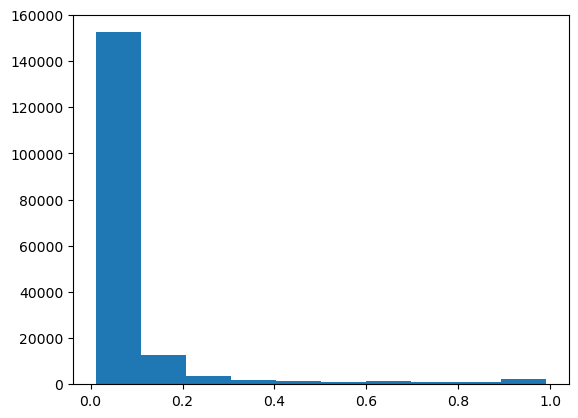

In [6]:
plt.figure()
plt.hist(values, bins=10)
plt.show

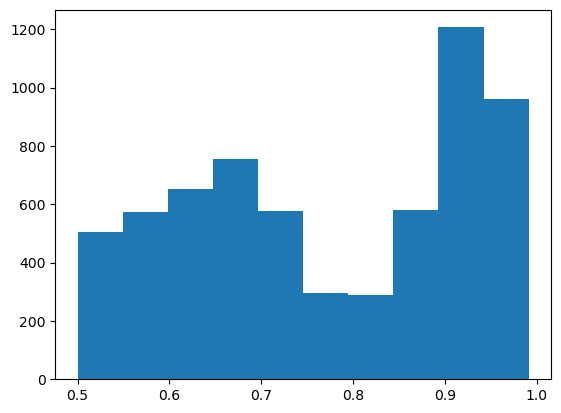

In [ ]:
values_filtered = values[values >= 0.5]
plt.figure()
plt.hist(values_filtered, bins=5)
plt.show()

In [15]:
import pandas as pd

df = pd.read_csv("../langdeath/doc/data/langdata.tsv", sep="\t")

df.head()

,integrated_code,L2,L1,endangered_aggregated_status,eth_status,cru_docs,cru_words,cru_floss_splchk,cru_watchtower,cru_udhr,...,wp_real_articles,wp_adjusted_size,uriel_feats,on_bible_org,in_leipzig_corpora,find_bible_all_versions,treetagger,endangered_langspec,endangered_lex,seed_label
0,aze_____________A,0.0,17.002976,0,1.0,747.0,111382.0,0,0,0,...,40435.0,5.224364e+08,0.0,0,1,6.0,0,0,0,v
1,ipk_____________A,0.0,8.682199,7,6.5,4.0,49574.0,0,0,0,...,NaN,NaN,0.0,0,0,7.0,0,0,0,-
2,kln_____________A,0.0,15.388990,0,5.0,77.0,124214.0,0,1,0,...,NaN,NaN,96.0,0,0,6.0,0,0,0,-
3,oji_____________A,0.0,11.428467,0,6.5,177.0,54742.0,0,0,0,...,NaN,NaN,0.0,0,0,17.0,0,0,0,-
4,cre_____________A,0.0,10.723994,6,5.0,5.0,8748.0,0,0,0,...,53.0,1.967746e+05,0.0,0,0,10.0,0,0,0,-


Ez fent 2016-os (legújabb adat)
az eredeti, pone... tsv a cikknél van

In [16]:
df = df[['integrated_code', 'cru_docs', 'cru_floss_splchk', 'cru_watchtower', 'cru_udhr']]
df.head()

,integrated_code,cru_docs,cru_floss_splchk,cru_watchtower,cru_udhr
0,aze_____________A,747.0,0,0,0
1,ipk_____________A,4.0,0,0,0
2,kln_____________A,77.0,0,1,0
3,oji_____________A,177.0,0,0,0
4,cre_____________A,5.0,0,0,0


In [12]:
map = pd.read_csv("../langdeath/doc/data/sil_2_integrated_code", delim_whitespace=True, header=None, names=["sil", "integrated_code"])
map.head()

C:\Users\martin\AppData\Local\Temp\ipykernel_10048\838962398.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  map = pd.read_csv("../langdeath/doc/data/sil_2_integrated_code", delim_whitespace=True, header=None, names=["sil", "integrated_code"])


,sil,integrated_code
0,sil,integrated_code
1,aze,aze_____________A
2,ipk,ipk_____________A
3,kln,kln_____________A
4,oji,oji_____________A


In [13]:
df_master = pd.read_csv("../data/master_features_by_code.csv")
df_master.head()

,code,iso639_3,glottocode,AdjustedWPsize,Articles,WPincubatornew,WPsizeinchars,Realtotalratio,Avggoodpagelength,Population Size,Digital Support,has_glottolog,has_bible,win11_os_supported,tatoeba_sentences,has_wals,Ethnologue_Status,has_wiki
0,aaa,aaa,ghot1243,NaN,NaN,0.0,NaN,NaN,NaN,3.0,1.0,1,0,0,NaN,1,2.0,0
1,aab,aab,alum1246,NaN,NaN,0.0,NaN,NaN,NaN,5.0,0.0,1,0,0,NaN,0,2.0,0
2,aac,aac,arii1243,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,1,0,0,NaN,0,1.0,0
3,aad,aad,amal1242,NaN,NaN,0.0,NaN,NaN,NaN,3.0,0.0,1,0,0,NaN,0,2.0,0
4,aae,aae,arbe1236,NaN,NaN,1.0,NaN,NaN,NaN,5.0,2.0,1,0,0,NaN,0,1.0,0


In [17]:
df_pone = pd.read_csv("../pone.tsv", sep="\t")
df_pone.head()

C:\Users\martin\AppData\Local\Temp\ipykernel_10048\2264360994.py:1: DtypeWarning: Columns (1,2,4,5,8,9,11,16,18,19,23,24,25,34,36,37,38,39,40,42,44,46,47,54,62,63,64,66,68,70,71,72,74,75,77,80,81,84,85,87,89,90) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pone = pd.read_csv("../pone.tsv", sep="\t")


,ID,FLOAT,FLOAT.1,X,BOOL,FLOAT.2,BOOL_HUN,X.1,X.2,FLOAT.3,...,BOOL_TLD,X.39,FLOAT.25,FLOAT.26,BOOL.13,FLOAT.27,X.40,INT,FLOAT.28,X.41
0,NaN,LOG,LOG,NaN,NaN,LOG,NaN,NaN,NaN,LOG,...,NaN,NaN,LOG,LOG,NaN,LOG,NaN,NaN,NaN,NaN
1,unique_join_code,la_Other resources in the language_All,la_Other resources about the language_Online,Comments,MS-if-pack,la_Other resources in the language_Online,hunspell status,cru2_Alternate names,character entropy*,la_Resources in the language_Online,...,TLDs(%),cru1_Name (English),L2,L1,MS-pack,la_Other resources about the language_All,cru2_Country,end_class,real/ total ratio,Id
2,xxe-nik-mil,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7,0,0
3,xtw,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8,0,xtw
4,xtv,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,xtv
